In [38]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import (
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta

from scipy.stats import norm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import pmdarima as pm

import matplotlib.pyplot as plt

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [48]:
df = pd.read_csv("data/salmon_concat.csv")
display(df)
df = df[["date", "count"]]
df

,date,count,70.2,cow bay,mainstem fence,skutz,vimy pool,ck,co
0,2014-05-01,7,NaN,NaN,NaN,NaN,NaN,True,False
1,2014-05-02,34,NaN,NaN,NaN,NaN,NaN,True,False
2,2014-05-07,21,NaN,NaN,NaN,NaN,NaN,True,False
3,2014-05-08,136,NaN,NaN,NaN,NaN,NaN,True,False
4,2014-05-13,74,NaN,NaN,NaN,NaN,NaN,True,False
...,...,...,...,...,...,...,...,...,...
582,2023-06-05,31,False,False,True,False,False,False,True
583,2023-06-06,590,False,False,True,False,False,True,False
584,2023-06-06,27,False,False,True,False,False,False,True
585,2023-06-07,604,False,False,True,False,False,True,False


,date,count
0,2014-05-01,7
1,2014-05-02,34
2,2014-05-07,21
3,2014-05-08,136
4,2014-05-13,74
...,...,...
582,2023-06-05,31
583,2023-06-06,590
584,2023-06-06,27
585,2023-06-07,604


In [49]:
df = df.groupby(["date"]).sum("count")
df = df.reset_index()
df

,date,count
0,2014-05-01,7
1,2014-05-02,34
2,2014-05-07,21
3,2014-05-08,136
4,2014-05-13,74
...,...,...
466,2023-06-02,500
467,2023-06-04,762
468,2023-06-05,560
469,2023-06-06,617


In [50]:
temp_df = pd.read_csv("data/northcochiwan_daily_temp-2.csv")
temp_df

,UTC_DATE,RELATIVE_HUMIDITY,WIND_SPEED,TEMP,WINDCHILL,DEW_POINT_TEMP
0,2013-09-02,75.818182,2.727273,19.127273,NaN,14.372727
1,2013-09-03,83.125000,2.458333,18.045833,NaN,14.766667
2,2013-09-04,85.791667,2.000000,17.062500,NaN,14.379167
3,2013-09-05,94.708333,1.541667,16.837500,NaN,15.900000
4,2013-09-06,91.916667,1.583333,16.954167,NaN,15.504167
...,...,...,...,...,...,...
3918,2024-05-26,75.125000,6.791667,11.083333,NaN,6.545833
3919,2024-05-27,79.166667,4.375000,12.491667,NaN,8.745833
3920,2024-05-28,78.708333,3.291667,12.520833,NaN,8.616667
3921,2024-05-29,67.625000,4.791667,11.154167,NaN,4.970833


In [51]:
flow_df = pd.read_csv("data/flow_2023.csv")
flow_df

,STATION_NUMBER,YEAR,MONTH,FLOW1,FLOW2,FLOW3,FLOW4,FLOW5,FLOW6,FLOW7,...,FLOW22,FLOW23,FLOW24,FLOW25,FLOW26,FLOW27,FLOW28,FLOW29,FLOW30,FLOW31
0,08HA001,2013,1,11.500000,10.300,9.390000,8.910000,8.650000,9.510000,16.200001,...,7.920000,8.400000,9.510,10.400,11.700,12.600,11.700000,10.700000,10.500000,12.300000
1,08HA001,2013,2,15.900000,15.000,13.800000,13.900000,21.799999,49.299999,51.200001,...,12.400000,15.300000,13.800,31.500,26.100,20.400,18.200001,NaN,NaN,NaN
2,08HA001,2013,3,156.000000,196.000,93.800003,51.200001,32.400002,21.799999,17.400000,...,29.200001,21.700001,17.500,14.600,12.800,11.900,12.300000,13.700000,15.500000,19.200001
3,08HA001,2013,4,22.799999,25.400,21.100000,20.000000,47.700001,74.000000,43.400002,...,14.900000,12.900000,12.200,13.300,15.800,16.600,17.000000,15.200000,12.000000,NaN
4,08HA001,2013,5,9.900000,9.110,9.690000,13.600000,17.500000,20.000000,19.700001,...,7.740000,8.020000,7.720,7.550,7.460,9.590,18.900000,17.799999,16.200001,13.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,08HA003,2023,8,0.243000,0.239,0.234000,0.220000,0.231000,0.245000,0.242000,...,0.148000,0.152000,0.159,0.178,0.196,0.202,0.200000,0.217000,0.213000,0.233000
261,08HA003,2023,9,0.246000,0.238,0.229000,0.234000,0.242000,0.237000,0.211000,...,0.176000,0.204000,0.214,0.295,0.389,0.443,0.433000,0.401000,0.353000,NaN
262,08HA003,2023,10,0.311000,0.323,0.392000,0.399000,0.355000,0.331000,0.320000,...,2.100000,1.510000,1.640,5.750,5.390,3.610,2.740000,2.260000,1.970000,1.820000
263,08HA003,2023,11,1.800000,21.400,21.799999,37.500000,27.299999,20.299999,15.800000,...,5.310000,4.800000,4.370,4.020,3.720,3.480,3.240000,3.050000,2.890000,NaN


In [52]:
all_columns=flow_df.iloc[:,3:].columns.tolist()
flow_df_pivoted = flow_df.melt(id_vars=["STATION_NUMBER", "YEAR", "MONTH"], var_name="Day", value_name="Flow")
flow_df_pivoted["Day"] = flow_df_pivoted["Day"].str.replace("FLOW", "").astype(int)
flow_df_pivoted["Date"] = flow_df_pivoted["YEAR"].astype(str) + "-" + flow_df_pivoted["MONTH"].astype(str) + "-" + flow_df_pivoted["Day"].astype(str)
flow_df_pivoted["Date"] = pd.to_datetime(flow_df_pivoted["Date"], errors='coerce', format='mixed')
flow_df_pivoted = flow_df_pivoted.dropna(subset=["Date"]).sort_values(by="Date")
flow_df_pivoted = flow_df_pivoted.groupby("Date").mean("Flow").reset_index()
flow_df_pivoted

,Date,YEAR,MONTH,Day,Flow
0,2013-01-01,2013.0,1.0,1.0,10.950
1,2013-01-02,2013.0,1.0,2.0,9.740
2,2013-01-03,2013.0,1.0,3.0,8.745
3,2013-01-04,2013.0,1.0,4.0,8.300
4,2013-01-05,2013.0,1.0,5.0,8.065
...,...,...,...,...,...
4043,2024-01-27,2024.0,1.0,27.0,NaN
4044,2024-01-28,2024.0,1.0,28.0,NaN
4045,2024-01-29,2024.0,1.0,29.0,NaN
4046,2024-01-30,2024.0,1.0,30.0,NaN


In [53]:
level_df = pd.read_csv("data/level_2023.csv")
level_df_pivoted = level_df.melt(id_vars=["STATION_NUMBER", "YEAR", "MONTH"], var_name="Day", value_name="Level")
level_df_pivoted["Day"] = level_df_pivoted["Day"].str.replace("LEVEL", "").astype(int)
level_df_pivoted["Date"] = level_df_pivoted["YEAR"].astype(str) + "-" + level_df_pivoted["MONTH"].astype(str) + "-" + level_df_pivoted["Day"].astype(str)
level_df_pivoted["Date"] = pd.to_datetime(level_df_pivoted["Date"], errors='coerce', format='mixed')
level_df_pivoted = level_df_pivoted.dropna(subset=["Date"]).sort_values(by="Date")
level_df_pivoted = level_df_pivoted.groupby("Date").mean("Level").reset_index()
level_df_pivoted

,Date,YEAR,MONTH,Day,Level
0,2013-01-01,2013.0,1.0,1.0,0.9470
1,2013-01-02,2013.0,1.0,2.0,0.9120
2,2013-01-03,2013.0,1.0,3.0,0.8815
3,2013-01-04,2013.0,1.0,4.0,0.8685
4,2013-01-05,2013.0,1.0,5.0,0.8610
...,...,...,...,...,...
4012,2023-12-27,2023.0,12.0,27.0,1.2440
4013,2023-12-28,2023.0,12.0,28.0,1.2460
4014,2023-12-29,2023.0,12.0,29.0,1.2680
4015,2023-12-30,2023.0,12.0,30.0,1.1695


In [54]:
df

,date,count
0,2014-05-01,7
1,2014-05-02,34
2,2014-05-07,21
3,2014-05-08,136
4,2014-05-13,74
...,...,...
466,2023-06-02,500
467,2023-06-04,762
468,2023-06-05,560
469,2023-06-06,617


In [55]:
comb = df.merge(temp_df[["UTC_DATE", "TEMP"]], left_on="date", right_on="UTC_DATE", how="right")
comb = comb.drop(["date"], axis=1)
comb["count"] = comb["count"].fillna(0)
comb = comb.rename(columns={"UTC_DATE": "date"})
comb["date"] = pd.to_datetime(comb["date"])
comb["month"] = comb["date"].dt.month
comb["year"] = comb["date"].dt.year
comb

,count,date,TEMP,month,year
0,0.0,2013-09-02,19.127273,9,2013
1,0.0,2013-09-03,18.045833,9,2013
2,0.0,2013-09-04,17.062500,9,2013
3,0.0,2013-09-05,16.837500,9,2013
4,0.0,2013-09-06,16.954167,9,2013
...,...,...,...,...,...
3918,0.0,2024-05-26,11.083333,5,2024
3919,0.0,2024-05-27,12.491667,5,2024
3920,0.0,2024-05-28,12.520833,5,2024
3921,0.0,2024-05-29,11.154167,5,2024


In [56]:
comb_df = comb.merge(flow_df_pivoted, left_on="date", right_on="Date")
comb_df = comb_df.merge(level_df_pivoted, left_on="date", right_on="Date")
keep_cols = ["date","month", "year",  "TEMP", "Flow", "Level", "count"]
comb_df = comb_df[keep_cols]
comb_df = comb_df.rename(columns={"TEMP": "Temp"})
comb_df

,date,month,year,Temp,Flow,Level,count
0,2013-09-02,9,2013,19.127273,0.875500,0.5480,0.0
1,2013-09-03,9,2013,18.045833,0.790500,0.5405,0.0
2,2013-09-04,9,2013,17.062500,0.749000,0.5365,0.0
3,2013-09-05,9,2013,16.837500,0.694500,0.5300,0.0
4,2013-09-06,9,2013,16.954167,0.668000,0.5280,0.0
...,...,...,...,...,...,...,...
3767,2023-12-27,12,2023,6.758333,28.499999,1.2440,0.0
3768,2023-12-28,12,2023,8.962500,30.200000,1.2460,0.0
3769,2023-12-29,12,2023,8.366667,31.400000,1.2680,0.0
3770,2023-12-30,12,2023,8.645833,23.600000,1.1695,0.0


In [57]:
month_key = {
      1: "january",
      2: "feburary",
      3: "march",
      4: "april",
      5: "may",
      6: "june",
      7: "july",
      8: "august",
      10: "october",
      11: "november",
      12: "december"
}

In [58]:
def parse_variables(df, variable, months, dict_key=month_key):

      for month in months:
            df[f"{dict_key[month]}_{variable}"] = 0

      for year in df["year"].unique().tolist():

            for month in months:
                  if month == 1 or month == 2:
                        temp_df = df[df["year"] == year]
                  else:
                        temp_df = df[df["year"] == year-1]
                  month_df = temp_df[temp_df["month"] == month]
                  month_avg = month_df[f"{variable}"].mean()

                  df.loc[(df["year"] == year), f"{dict_key[month]}_{variable}"] = month_avg

      return df

new_df = parse_variables(comb_df, "Flow", [10,11])
new_df = parse_variables(comb_df, "Temp", [12, 1, 2])
new_df = parse_variables(comb_df, "Level", [10, 11])
new_df

,date,month,year,Temp,Flow,Level,count,october_Flow,november_Flow,december_Temp,january_Temp,feburary_Temp,october_Level,november_Level
0,2013-09-02,9,2013,19.127273,0.875500,0.5480,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-09-03,9,2013,18.045833,0.790500,0.5405,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-09-04,9,2013,17.062500,0.749000,0.5365,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-09-05,9,2013,16.837500,0.694500,0.5300,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-09-06,9,2013,16.954167,0.668000,0.5280,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,2023-12-27,12,2023,6.758333,28.499999,1.2440,0.0,0.996387,3.854583,1.01586,4.861828,3.270828,0.675435,0.829067
3768,2023-12-28,12,2023,8.962500,30.200000,1.2460,0.0,0.996387,3.854583,1.01586,4.861828,3.270828,0.675435,0.829067
3769,2023-12-29,12,2023,8.366667,31.400000,1.2680,0.0,0.996387,3.854583,1.01586,4.861828,3.270828,0.675435,0.829067
3770,2023-12-30,12,2023,8.645833,23.600000,1.1695,0.0,0.996387,3.854583,1.01586,4.861828,3.270828,0.675435,0.829067


In [59]:
new_df.to_csv("data/jenny/new_df2.csv", index=False)

In [34]:
new_df = new_df[(new_df["year"] > 2015) & (new_df["year"] <= 2024)]
new_df.tail(5)

,date,month,year,Temp,Flow,Level,count,october_Flow,november_Flow,december_Temp,january_Temp,feburary_Temp,october_Level,november_Level,rolling_mean_Temp,rolling_std_Temp,rolling_mean_Flow,rolling_std_Flow,rolling_mean_Level,rolling_std_Level
2710,2020-12-27,12,2020,3.604545,51.450001,1.6530,0.0,7.679129,8.111167,4.676562,3.763815,4.143247,0.795806,0.812433,4.125538,2.670628,32.185667,21.227261,1.344200,0.274282
2711,2020-12-28,12,2020,5.133333,54.049999,1.6890,0.0,7.679129,8.111167,4.676562,3.763815,4.143247,0.795806,0.812433,4.074844,2.635173,32.329000,21.364027,1.350783,0.280245
2712,2020-12-29,12,2020,2.141667,36.500000,1.4865,0.0,7.679129,8.111167,4.676562,3.763815,4.143247,0.795806,0.812433,4.041649,2.653595,32.602333,21.363158,1.357433,0.281045
2713,2020-12-30,12,2020,4.216667,61.850000,1.7570,0.0,7.679129,8.111167,4.676562,3.763815,4.143247,0.795806,0.812433,3.954288,2.600997,33.617333,22.017411,1.371900,0.290231
2714,2020-12-31,12,2020,6.418182,100.849998,2.1535,0.0,7.679129,8.111167,4.676562,3.763815,4.143247,0.795806,0.812433,4.083506,2.624583,36.072333,25.159124,1.401000,0.322701


In [60]:
def rolling_temp(df, variables, windows):
      for variable in variables:
        df[f"rolling_mean_{variable}"] = df[f"{variable}"].rolling(windows).mean()
        df[f"rolling_std_{variable}"] = df[f"{variable}"].rolling(windows).std()
      return df

def lag_df(df, numeric_cols, lag=1):
    lagged_df = pd.DataFrame()
    for col in numeric_cols:
        for i in range(lag + 1):
            lagged_df[f'{col}_t-{i}'] = df[col].shift(i)
    return lagged_df.dropna()

new_df = rolling_temp(new_df, ["Temp", "Flow", "Level"], 30)
# df_lag = lag_df(new_df, ["Temp", "Flow", "Level"], lag=30)
# df_ready = pd.concat([new_df, df_lag], axis=1)
new_df

,date,month,year,Temp,Flow,Level,count,october_Flow,november_Flow,december_Temp,january_Temp,feburary_Temp,october_Level,november_Level,rolling_mean_Temp,rolling_std_Temp,rolling_mean_Flow,rolling_std_Flow,rolling_mean_Level,rolling_std_Level
0,2013-09-02,9,2013,19.127273,0.875500,0.5480,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-09-03,9,2013,18.045833,0.790500,0.5405,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-09-04,9,2013,17.062500,0.749000,0.5365,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-09-05,9,2013,16.837500,0.694500,0.5300,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-09-06,9,2013,16.954167,0.668000,0.5280,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,2023-12-27,12,2023,6.758333,28.499999,1.2440,0.0,0.996387,3.854583,1.01586,4.861828,3.270828,0.675435,0.829067,5.307917,2.217812,24.808667,26.852532,1.150467,0.320490
3768,2023-12-28,12,2023,8.962500,30.200000,1.2460,0.0,0.996387,3.854583,1.01586,4.861828,3.270828,0.675435,0.829067,5.535972,2.230511,25.657167,26.597649,1.166617,0.312316
3769,2023-12-29,12,2023,8.366667,31.400000,1.2680,0.0,0.996387,3.854583,1.01586,4.861828,3.270828,0.675435,0.829067,5.737222,2.203401,26.555333,26.310389,1.183850,0.302708
3770,2023-12-30,12,2023,8.645833,23.600000,1.1695,0.0,0.996387,3.854583,1.01586,4.861828,3.270828,0.675435,0.829067,5.941250,2.178952,27.200500,25.979671,1.198083,0.291055


In [61]:
def impute_for_missing(df):
      missing_cols = df.columns[df.isna().any()].tolist()
      for col in missing_cols:
            median_value = df[col].median()
            df[col].fillna(median_value, inplace=True)
      return df

In [62]:
trial_df = impute_for_missing(new_df)
# trial_df = pd.concat([trial_df, new_df["count"]], axis=1)
trial_df.tail(3)

/var/folders/c5/pphx1c0n3lb12sy85_ybqxqm0000gn/T/ipykernel_24408/2039789980.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_value, inplace=True)
/var/folders/c5/pphx1c0n3lb12sy85_ybqxqm0000gn/T/ipykernel_24408/2039789980.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

,date,month,year,Temp,Flow,Level,count,october_Flow,november_Flow,december_Temp,january_Temp,feburary_Temp,october_Level,november_Level,rolling_mean_Temp,rolling_std_Temp,rolling_mean_Flow,rolling_std_Flow,rolling_mean_Level,rolling_std_Level
3769,2023-12-29,12,2023,8.366667,31.4,1.2680,0.0,0.996387,3.854583,1.01586,4.861828,3.270828,0.675435,0.829067,5.737222,2.203401,26.555333,26.310389,1.183850,0.302708
3770,2023-12-30,12,2023,8.645833,23.6,1.1695,0.0,0.996387,3.854583,1.01586,4.861828,3.270828,0.675435,0.829067,5.941250,2.178952,27.200500,25.979671,1.198083,0.291055
3771,2023-12-31,12,2023,6.516667,18.8,1.0930,0.0,0.996387,3.854583,1.01586,4.861828,3.270828,0.675435,0.829067,6.013611,2.160107,27.673667,25.681505,1.209333,0.279657


In [64]:
trial_df.to_csv("data/jenny/new_df2.csv", index=False)

In [ ]:
trial_df[trial_df[(trial_df["year"] == 2017) & (trial_df["month"] == )]]

In [54]:
def truncate_months(df, months_keep=[4,5,6,7,8]):
      df = df[df["month"].isin(months_keep)]
      return df

short_months_df = truncate_months(trial_df)
short_months_df.shape

(818, 20)

In [36]:
# trial_df.to_csv("data/jenny/new_df.csv", index=False)

In [55]:
use_for_feats = trial_df.iloc[:,7:20].columns.tolist()
use_for_feats

['october_Flow',
 'november_Flow',
 'december_Temp',
 'january_Temp',
 'feburary_Temp',
 'october_Level',
 'november_Level',
 'rolling_mean_Temp',
 'rolling_std_Temp',
 'rolling_mean_Flow',
 'rolling_std_Flow',
 'rolling_mean_Level',
 'rolling_std_Level']

In [56]:
scaler = MinMaxScaler(feature_range=(0, 1))
rf_df = trial_df.copy()
rf_df[use_for_feats] = scaler.fit_transform(rf_df[use_for_feats])
target = "count"

model = pm.auto_arima(rf_df['count'], 
                        m=12, seasonal=True,
                        start_p=0, start_q=0, max_order=4, test='adf',error_action='ignore',  
                        suppress_warnings=True, stepwise=True, trace=True)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=23073.731, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=23221.839, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=22763.020, Time=0.57 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=22813.652, Time=0.91 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=23283.978, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=22812.403, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=22760.676, Time=1.64 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=22759.918, Time=4.63 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=22758.334, Time=1.34 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=22758.399, Time=0.38 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=22760.023, Time=4.21 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=22758.842, Time=1.49 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=22761.670, Time=3.96 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=22751.528, Time=2.02 sec
 ARIM

['october_Flow', 'november_Flow', 'december_Temp', 'january_Temp', 'feburary_Temp', 'october_Level', 'november_Level', 'rolling_mean_Temp', 'rolling_std_Temp', 'rolling_mean_Flow', 'rolling_std_Flow', 'rolling_mean_Level', 'rolling_std_Level']


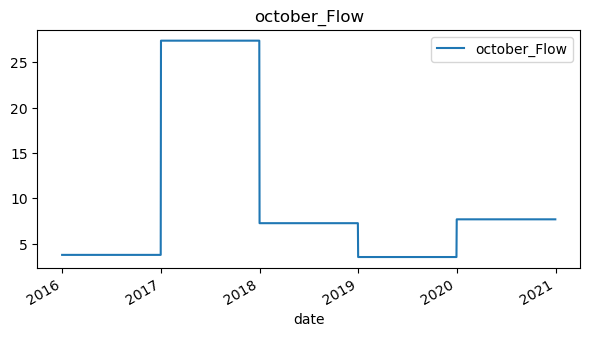

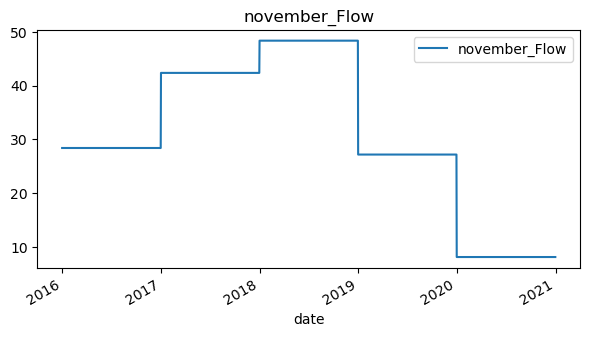

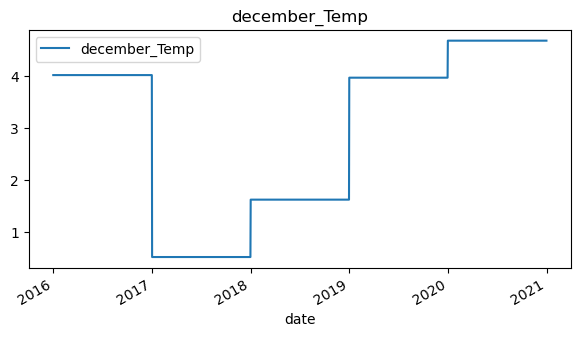

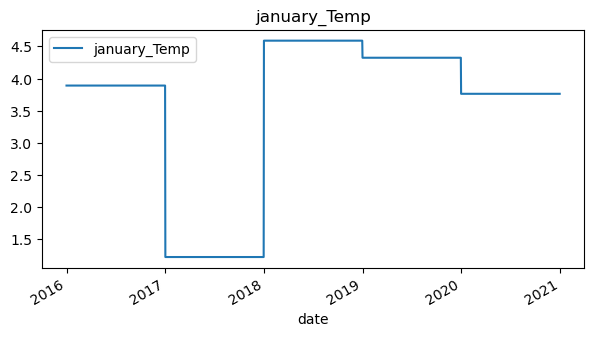

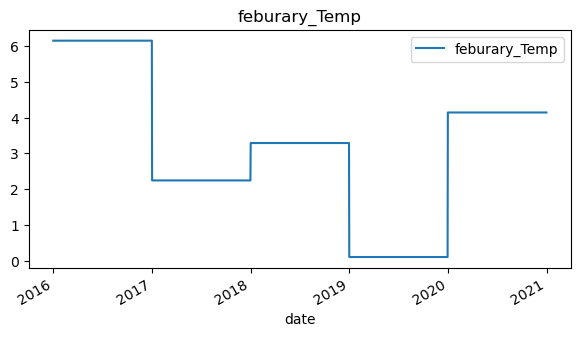

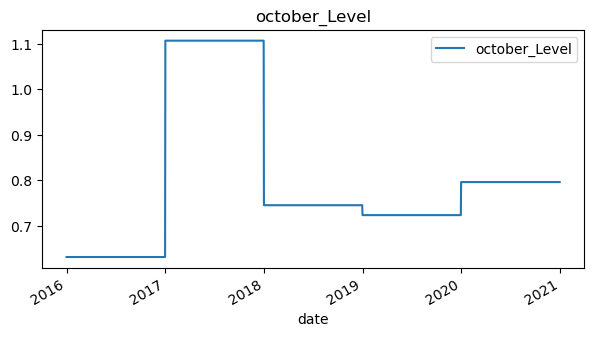

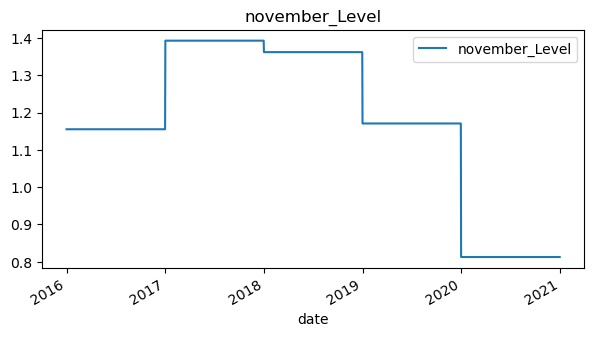

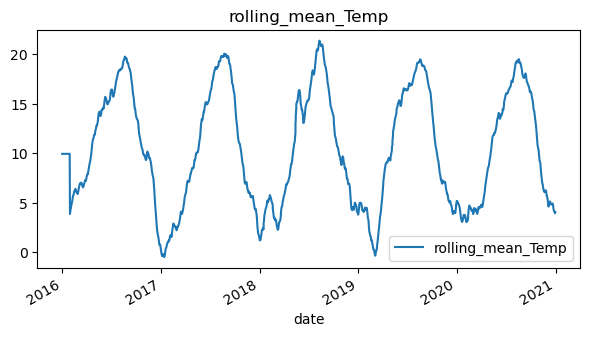

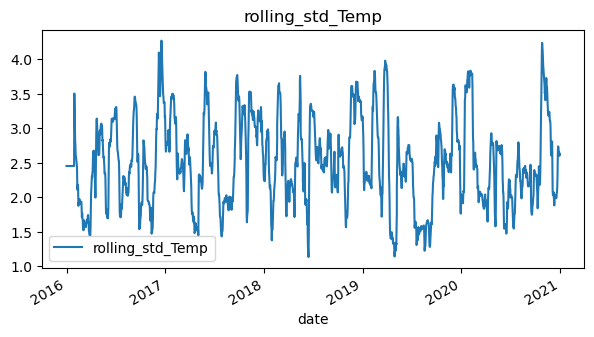

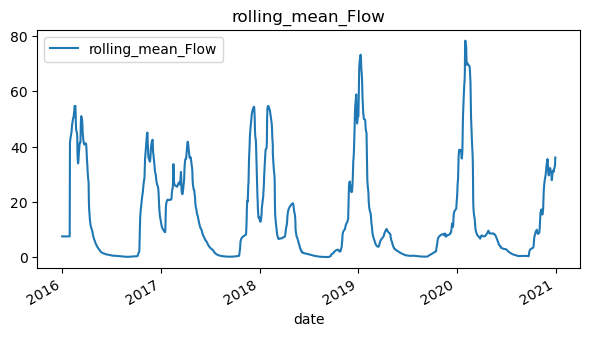

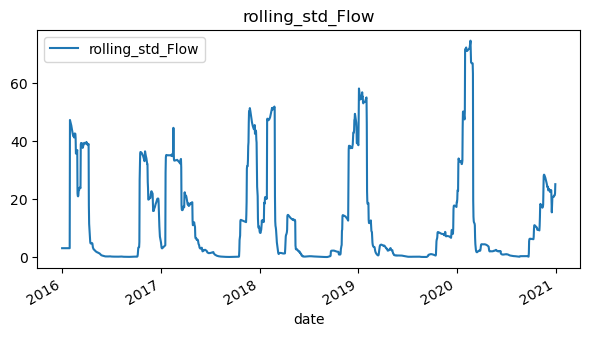

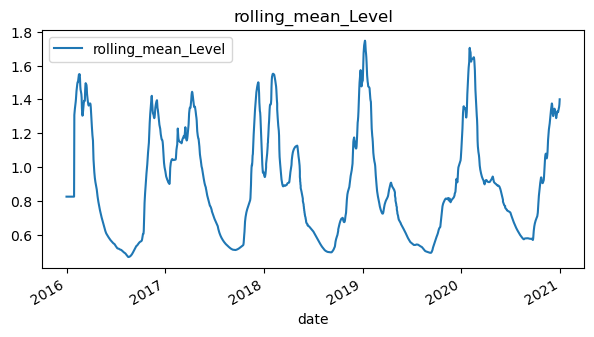

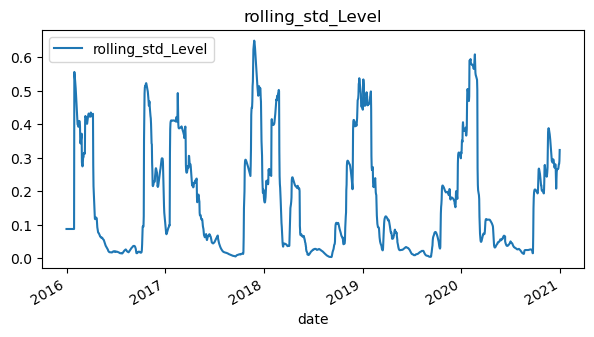

In [63]:
### 
# trial_df = trial_df.set_index("date")
trial_df2 = trial_df[use_for_feats]
print(trial_df2.columns.tolist())
for column in use_for_feats:
      trial_temp = trial_df2[[column]]
      fig, ax=plt.subplots(figsize=(7, 3.5))
      trial_temp.plot(ax=ax)
      plt.title(f"{column}")
      plt.show()

,date,month,year,Temp,Flow,Level,count,october_Flow,november_Flow,december_Temp,january_Temp,feburary_Temp,october_Level,november_Level,rolling_mean_Temp,rolling_std_Temp,rolling_mean_Flow,rolling_std_Flow,rolling_mean_Level,rolling_std_Level
850,2016-01-01,1,2016,-3.008333,6.985000,0.8045,0.0,3.760242,28.382500,4.015097,3.892070,6.152299,0.630677,1.155083,9.959583,2.453405,7.616408,3.065138,0.826092,0.087009
851,2016-01-02,1,2016,-2.387500,6.485000,0.7865,0.0,3.760242,28.382500,4.015097,3.892070,6.152299,0.630677,1.155083,9.959583,2.453405,7.616408,3.065138,0.826092,0.087009
852,2016-01-03,1,2016,-1.479167,6.095000,0.7725,0.0,3.760242,28.382500,4.015097,3.892070,6.152299,0.630677,1.155083,9.959583,2.453405,7.616408,3.065138,0.826092,0.087009
853,2016-01-04,1,2016,1.016667,5.890000,0.7660,0.0,3.760242,28.382500,4.015097,3.892070,6.152299,0.630677,1.155083,9.959583,2.453405,7.616408,3.065138,0.826092,0.087009
854,2016-01-05,1,2016,-0.091667,5.695000,0.7590,0.0,3.760242,28.382500,4.015097,3.892070,6.152299,0.630677,1.155083,9.959583,2.453405,7.616408,3.065138,0.826092,0.087009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2734,2020-12-27,12,2020,3.604545,51.450001,1.6530,0.0,7.679129,8.111167,4.676562,3.763815,4.143247,0.795806,0.812433,4.125538,2.670628,32.185667,21.227261,1.344200,0.274282
2735,2020-12-28,12,2020,5.133333,54.049999,1.6890,0.0,7.679129,8.111167,4.676562,3.763815,4.143247,0.795806,0.812433,4.074844,2.635173,32.329000,21.364027,1.350783,0.280245
2736,2020-12-29,12,2020,2.141667,36.500000,1.4865,0.0,7.679129,8.111167,4.676562,3.763815,4.143247,0.795806,0.812433,4.041649,2.653595,32.602333,21.363158,1.357433,0.281045
2737,2020-12-30,12,2020,4.216667,61.850000,1.7570,0.0,7.679129,8.111167,4.676562,3.763815,4.143247,0.795806,0.812433,3.954288,2.600997,33.617333,22.017411,1.371900,0.290231


In [45]:
train = trial_df[trial_df["date"] <= "2020-01-01"]
test = trial_df[trial_df["date"] > "2020-01-01"]
print(test.shape, train.shape)

(374, 20) (1515, 20)


In [46]:
model.fit(train['count'])

ARIMA(order=(5, 0, 4), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True)

In [52]:
forecast=model.predict(n_periods=360, return_conf_int=False)

/Users/jennylee/miniforge3/envs/563/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/jennylee/miniforge3/envs/563/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [53]:
forecast

1515     7.503539
1516    15.202437
1517    11.419158
1518    18.132215
1519    16.684377
          ...    
1870    36.869519
1871    36.869448
1872    36.869605
1873    36.869372
1874    36.869484
Length: 360, dtype: float64

In [49]:
test

,date,month,year,Temp,Flow,Level,count,october_Flow,november_Flow,december_Temp,january_Temp,feburary_Temp,october_Level,november_Level,rolling_mean_Temp,rolling_std_Temp,rolling_mean_Flow,rolling_std_Flow,rolling_mean_Level,rolling_std_Level
2365,2020-01-02,1,2020,3.904167,30.900000,1.3335,0.0,7.679129,8.111167,4.676562,3.763815,4.143247,0.795806,0.812433,5.081389,2.019072,21.413000,18.925371,1.107467,0.312088
2366,2020-01-03,1,2020,6.050000,60.349998,1.6735,0.0,7.679129,8.111167,4.676562,3.763815,4.143247,0.795806,0.812433,5.131389,2.024026,23.245833,19.952265,1.137767,0.321623
2367,2020-01-04,1,2020,5.741667,89.700001,1.9965,0.0,7.679129,8.111167,4.676562,3.763815,4.143247,0.795806,0.812433,5.125694,2.021992,26.058833,23.045507,1.178950,0.349600
2368,2020-01-05,1,2020,5.158333,50.299999,1.6250,0.0,7.679129,8.111167,4.676562,3.763815,4.143247,0.795806,0.812433,5.059861,1.986207,27.515167,23.154292,1.206300,0.351386
2369,2020-01-06,1,2020,3.783333,38.250000,1.4670,0.0,7.679129,8.111167,4.676562,3.763815,4.143247,0.795806,0.812433,4.948889,1.960404,28.553833,22.903998,1.227783,0.346783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2734,2020-12-27,12,2020,3.604545,51.450001,1.6530,0.0,7.679129,8.111167,4.676562,3.763815,4.143247,0.795806,0.812433,4.125538,2.670628,32.185667,21.227261,1.344200,0.274282
2735,2020-12-28,12,2020,5.133333,54.049999,1.6890,0.0,7.679129,8.111167,4.676562,3.763815,4.143247,0.795806,0.812433,4.074844,2.635173,32.329000,21.364027,1.350783,0.280245
2736,2020-12-29,12,2020,2.141667,36.500000,1.4865,0.0,7.679129,8.111167,4.676562,3.763815,4.143247,0.795806,0.812433,4.041649,2.653595,32.602333,21.363158,1.357433,0.281045
2737,2020-12-30,12,2020,4.216667,61.850000,1.7570,0.0,7.679129,8.111167,4.676562,3.763815,4.143247,0.795806,0.812433,3.954288,2.600997,33.617333,22.017411,1.371900,0.290231


In [48]:
forecast

(1515     7.503539
 1516    15.202437
 1517    11.419158
 1518    18.132215
 dtype: float64,
 array([[-194.11586132,  209.12293891],
        [-204.49728651,  234.90216077],
        [-211.84934269,  234.6876588 ],
        [-213.41230464,  249.67673477]]))

In [ ]:
train=rf_df[(rf_df.index.get_level_values(0) >= '2012-01-31') & (rf_df.index.get_level_values(0) <= '2017-04-30')]

In [17]:
scaler = MinMaxScaler(feature_range=(0, 1))
lstm_df = trial_df.copy().iloc[len(trial_df)-100:,]
lstm_df[use_for_feats] = scaler.fit_transform(lstm_df[use_for_feats])
target = "count"

# Split the data into training and testing sets
train_size = int(len(lstm_df) * 0.8)
train_data = lstm_df[:train_size]
test_data = lstm_df[train_size:]

# Create sequences for the LSTM model
def create_sequences(data, features, target, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[features].iloc[i:(i + time_steps)].values)
        y.append(data[target].iloc[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 10
X_train, y_train = create_sequences(train_data, use_for_feats, target, time_steps)
X_test, y_test = create_sequences(test_data, use_for_feats, target, time_steps)

In [18]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, len(use_for_feats))))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, shuffle=False)

Epoch 1/50


/Users/jennylee/miniforge3/envs/563/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
trial_df = comb_.copy()
trial_df = impute_for_missing(trial_df)
split_date = "2019-12-30"
display(trial_df.head(6))
trial_df = trial_df.set_index('date')
trial_df['count'] = trial_df['count'].fillna(0)
exog = trial_df[['TEMP', 'december_temp', 'january_temp', 'feburary_temp', 'october_temp', 'november_temp']]

train_data = trial_df[trial_df.index < split_date]
test_data = trial_df[trial_df.index >= split_date]
train_exog = exog[exog.index < split_date]
test_exog = exog[exog.index >= split_date]

print("Train Data Indices:", train_data.index)
print("Test Data Indices:", test_data.index)


/var/folders/c5/pphx1c0n3lb12sy85_ybqxqm0000gn/T/ipykernel_50234/2039789980.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_value, inplace=True)
/var/folders/c5/pphx1c0n3lb12sy85_ybqxqm0000gn/T/ipykernel_50234/2039789980.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

,count,date,TEMP,month,year,december_temp,january_temp,feburary_temp,october_temp,november_temp,rolling_mean,rolling_std
850,0.0,2016-01-01,-3.008333,1,2016,4.015097,5.092313,7.176082,11.646505,4.361111,9.959583,2.453405
851,0.0,2016-01-02,-2.387500,1,2016,4.015097,5.092313,7.176082,11.646505,4.361111,9.959583,2.453405
852,0.0,2016-01-03,-1.479167,1,2016,4.015097,5.092313,7.176082,11.646505,4.361111,9.959583,2.453405
853,0.0,2016-01-04,1.016667,1,2016,4.015097,5.092313,7.176082,11.646505,4.361111,9.959583,2.453405
854,0.0,2016-01-05,-0.091667,1,2016,4.015097,5.092313,7.176082,11.646505,4.361111,9.959583,2.453405
855,0.0,2016-01-06,2.262500,1,2016,4.015097,5.092313,7.176082,11.646505,4.361111,9.959583,2.453405


Train Data Indices: DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10',
               ...
               '2019-12-20', '2019-12-21', '2019-12-22', '2019-12-23',
               '2019-12-24', '2019-12-25', '2019-12-26', '2019-12-27',
               '2019-12-28', '2019-12-29'],
              dtype='datetime64[ns]', name='date', length=1512, freq=None)
Test Data Indices: DatetimeIndex(['2019-12-30', '2019-12-31', '2020-01-01', '2020-01-02',
               '2020-01-03', '2020-01-04', '2020-01-05', '2020-01-06',
               '2020-01-07', '2020-01-08',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='date', length=377, freq=None)


In [ ]:
test_data.index[0]

Timestamp('2019-12-30 00:00:00')

In [ ]:
train_data[exog.columns]

,TEMP,december_temp,january_temp,feburary_temp,october_temp,november_temp
date,,,,,,
2016-01-01,-3.008333,4.015097,5.092313,7.176082,11.646505,4.361111
2016-01-02,-2.387500,4.015097,5.092313,7.176082,11.646505,4.361111
2016-01-03,-1.479167,4.015097,5.092313,7.176082,11.646505,4.361111
2016-01-04,1.016667,4.015097,5.092313,7.176082,11.646505,4.361111
2016-01-05,-0.091667,4.015097,5.092313,7.176082,11.646505,4.361111
...,...,...,...,...,...,...
2019-12-25,3.900000,3.965188,4.590595,3.289368,9.090104,6.798333
2019-12-26,1.175000,3.965188,4.590595,3.289368,9.090104,6.798333
2019-12-27,2.620833,3.965188,4.590595,3.289368,9.090104,6.798333


In [ ]:
import pmdarima as pm
autoarima = pm.auto_arima(train_data.count, start_q=0, start_d=1, start_p=0,
                          max_q=5, max_d=2, max_p=5, seasonal=True)
autoarima.summary()

TypeError: float() argument must be a string or a real number, not 'method'

In [ ]:
model = SARIMAX(endog=train_data['count'], exog=train_data[exog.columns], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=False, maxiter=100)

start_date = test_data.index[0]  # Example start date
if start_date not in test_data.index:
    print("Start date is not in the index of test_data.")
else:
    print("Start date is in the index of test_data.")

/Users/jennylee/miniforge3/envs/563/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/jennylee/miniforge3/envs/563/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Start date is in the index of test_data.


In [ ]:
model_fit.forecast(1)

/Users/jennylee/miniforge3/envs/563/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/jennylee/miniforge3/envs/563/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


ValueError: Out-of-sample operations in a model with a regression component require additional exogenous values via the `exog` argument.

In [ ]:
pred = model_fit.get_prediction(start=test_data.index[0], end=test_data.index[-1], exog=test_exog, dynamic=False)
pred_ci = pred.conf_int()

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'